In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Initial Predictions

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/ahmetsirel/ozu_data_science/master/M5%20-%20General%20Linear%20Models/cell2cell-v1.csv")
data = data.drop(["Unnamed: 0",	"X",	"customer",	"traintest", "churndep"], axis=1)

In [4]:
def prepare_data(exclude_columns=None):
    data = pd.read_csv("https://raw.githubusercontent.com/ahmetsirel/ozu_data_science/master/M5%20-%20General%20Linear%20Models/cell2cell-v1.csv")
    data = data.drop(["Unnamed: 0",	"X",	"customer",	"traintest", "churndep"], axis=1)
    
    if exclude_columns is not None:
        data = data.drop(exclude_columns, axis=1)

    data = data.dropna(subset=["revenue"])
    x = data.drop('revenue', axis=1)
    
    y = data['revenue']

    

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)
    return x_train, x_test, y_train, y_test

In [5]:
def scale_data(x_train, x_test, scaler=StandardScaler):

    scaler = scaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)

    x_train_scaled.fillna(x_train_scaled.mean(), inplace=True)
    x_test_scaled.fillna(x_test_scaled.mean(), inplace=True)

    return x_train_scaled, x_test_scaled



In [6]:
def evaluate_regression(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name=""):   
    return pd.DataFrame.from_records([[
                                       metrics.mean_squared_error(y_true_train, y_pred_train),
                                       metrics.mean_absolute_error(y_true_train, y_pred_train),
                                       metrics.max_error(y_true_train, y_pred_train),
                                       metrics.r2_score(y_true_train, y_pred_train), 
                                      metrics.mean_squared_error(y_true_test, y_pred_test),
                                       metrics.mean_absolute_error(y_true_test, y_pred_test),
                                       metrics.max_error(y_true_test, y_pred_test),
                                       metrics.r2_score(y_true_test, y_pred_test)]], 
                                     
                                     index=[model_name], 
                                     columns=['mean_squared_error_train', 'mean_absolute_error_train', 'max_error_train', "r2_score_train",
                                              'mean_squared_error_test', 'mean_absolute_error_test', 'max_error_test', "r2_score_test"])


In [7]:
def run_models(x_train, x_test, y_train, y_test):
        results = pd.DataFrame()
        for model in [linear_model.LinearRegression(), 
                linear_model.RidgeCV(),
                linear_model.LassoCV(),
                svm.SVR(kernel="linear"),
                svm.SVR(kernel="rbf"),
                svm.SVR(kernel="poly"),
                tree.DecisionTreeRegressor()]:
                model.fit(x_train, y_train)

                y_train_pred = model.predict(x_train)
                y_test_pred = model.predict(x_test)

                results = results.append(evaluate_regression(y_train, y_train_pred, y_test, y_test_pred,
                                        model_name=model))
        return results


In [8]:
def run(exclude_columns=None):
    x_train, x_test, y_train, y_test = prepare_data(exclude_columns=exclude_columns)
    x_train, x_test = scale_data(x_train, x_test, scaler=StandardScaler)
    results = run_models(x_train, x_test, y_train, y_test)
    print("Min RMSE Test",results.sort_values("RMSE_test").iloc[0]["RMSE_test"])
    return results.sort_values("RMSE_test")

In [9]:
results = run(exclude_columns=None)
results

# (i) variable interaction

In [98]:
corr = data.corr().unstack().reset_index(name='corr').rename(columns={'level_0': 'V1', 'level_1': 'V2'})
corr['corr_abs'] = np.abs(corr['corr'])
corr = corr[corr.V1 != corr.V2]
corr = corr.sort_values('corr_abs', ascending=False)
corr_with_label = corr[corr.V1 == "revenue"].copy()
corr['key'] = corr.apply(lambda x: str(sorted((x.V1, x.V2))) , axis=1)

corr = corr.drop_duplicates(subset='key').drop('key', axis=1)


len(corr)

2211

## Detect the columns with high correlation with each other and drop the one has lower corr with LABEL

In [99]:
corr_wide = corr.merge(corr_with_label[["V2","corr","corr_abs"]], left_on="V1", right_on="V2" , how="left", suffixes=(None, "_V1_corr_with_label")).drop("V2_V1_corr_with_label",axis=1).merge(corr_with_label[["V2","corr","corr_abs"]], left_on="V2", right_on="V2" , how="left", suffixes=(None, "_V2_corr_with_label"))#.drop("V2_V2_corr_with_label",axis=1)
corr_wide.head()

,V1,V2,corr,corr_abs,corr_V1_corr_with_label,corr_abs_V1_corr_with_label,corr_V2_corr_with_label,corr_abs_V2_corr_with_label
0,mailres,mailord,0.967843,0.967843,-0.098265,0.098265,-0.096903,0.096903
1,retcall,retcalls,0.957813,0.957813,0.014550,0.014550,0.015345,0.015345
2,models,phones,0.889472,0.889472,0.238935,0.238935,0.245192,0.245192
3,mourec,mou,0.832720,0.832720,0.607243,0.607243,0.711411,0.711411
4,incmiss,creditcd,-0.819104,0.819104,0.078708,0.078708,-0.087428,0.087428


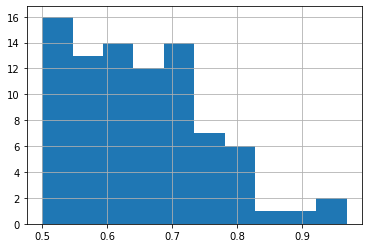

In [100]:
corr[corr.corr_abs >= 0.5].corr_abs.hist()

In [101]:
def columns_to_drop(row):
    if row.corr_abs_V1_corr_with_label > row.corr_abs_V2_corr_with_label:
        row["column_to_drop"] = row.V2 
        row["corr_with_label_column_to_drop"] = row.corr_abs_V2_corr_with_label
    
    else:
        row["column_to_drop"] = row.V1 
        row["corr_with_label_column_to_drop"] = row.corr_abs_V1_corr_with_label
    return row

corr_wide = corr_wide.apply(columns_to_drop, axis=1)
corr_wide.head()

,V1,V2,corr,corr_abs,corr_V1_corr_with_label,corr_abs_V1_corr_with_label,corr_V2_corr_with_label,corr_abs_V2_corr_with_label,column_to_drop,corr_with_label_column_to_drop
0,mailres,mailord,0.967843,0.967843,-0.098265,0.098265,-0.096903,0.096903,mailord,0.096903
1,retcall,retcalls,0.957813,0.957813,0.014550,0.014550,0.015345,0.015345,retcall,0.014550
2,models,phones,0.889472,0.889472,0.238935,0.238935,0.245192,0.245192,models,0.238935
3,mourec,mou,0.832720,0.832720,0.607243,0.607243,0.711411,0.711411,mourec,0.607243
4,incmiss,creditcd,-0.819104,0.819104,0.078708,0.078708,-0.087428,0.087428,incmiss,0.078708


In [123]:
columns_to_drop_high_corr = corr_wide[(corr_wide.corr_abs >= 0.8) ].column_to_drop.unique().tolist()
columns_to_drop_high_corr

['mailord', 'retcall', 'models', 'mourec', 'incmiss', 'blckvce', 'creditcd']

## Columns with low corr. with the label columns.

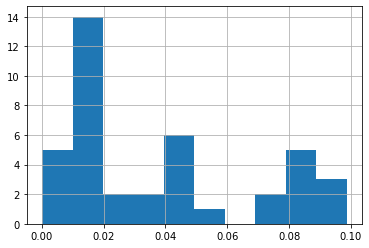

In [129]:
corr_with_label[corr_with_label.corr_abs<0.1].corr_abs.hist()

In [135]:
columns_to_drop_low_corr_with_label = corr_with_label[corr_with_label.corr_abs<0.1].V2.unique().tolist()

## Experiments

In [ ]:
run(exclude_columns=columns_to_drop_high_corr)


In [ ]:
run(exclude_columns=columns_to_drop_low_corr_with_label)

In [ ]:
run(exclude_columns=list(set(columns_to_drop_high_corr+columns_to_drop_low_corr_with_label)))

# (ii) variable transformation

# (iii)multi-collinearity issues

# (iv) feature elimination & selection

# (v) model selection